In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
import math 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#data = genfromtxt('small_file_correct_coord.txt', delimiter=',')
data = genfromtxt('test_output_false_negative.txt', delimiter=',')
#data = genfromtxt('small_file.txt', delimiter=',')
data[:,4] =(data[:,4]-np.min(data[:,4]))/(np.max(data[:,4])-np.min(data[:,4]))
print(data)

[[ 0.00000000e+00  1.12801600e+00  9.13283000e-01 -2.69977000e+00
   3.20532033e-01]
 [ 1.00000000e+00  9.52915000e-01  5.19144000e-01  8.78809000e-01
   9.30878204e-01]
 [ 1.00000000e+00  4.34082000e-01  5.67670000e-01 -2.31193600e+00
   9.16612795e-01]
 ...
 [ 9.71800000e+03  2.11805000e+00  6.91111000e-01  1.31600900e+00
   5.89230502e-01]
 [ 9.71900000e+03  1.61018700e+00  1.01372300e+00  2.24618800e+00
   5.36947139e-01]
 [ 9.71900000e+03  1.41488000e-01  1.47488600e+00 -4.42010000e-01
   5.20508288e-01]]


In [3]:
ll = []
true_vals = []
print(int(np.max(data,axis=0)[0]))
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    #print("This is mask:")
    #print(mask)
    evt = data[mask]
    #print(evt)
    #print(evt.shape[0])
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    for i, (idx1, idx2) in enumerate(pair_indices):
        l = []
        print("this are the pairs to be compared")
        print(evt[idx1,1:])
        print(evt[idx2,1:])
        ### this is the new stuff....
        time_diff = abs(evt[idx1,4]-evt[idx2,4])
        ene_diff = abs(evt[idx1,1]-evt[idx2,1])
        min_theta = evt[idx1,2] if evt[idx2,2] > evt[idx1,2] else evt[idx2,2]
        max_theta = evt[idx2,2] if evt[idx2,2] > evt[idx1,2] else evt[idx1,2]
        theta_diff = abs(max_theta-min_theta) if (abs(max_theta-min_theta) < abs(max_theta-(min_theta+math.pi))) else abs(max_theta-(min_theta+math.pi)) 
        min_phi = evt[idx1,3] if evt[idx2,3] > evt[idx1,3] else evt[idx2,3]
        max_phi = evt[idx2,3] if evt[idx2,3] > evt[idx1,3] else evt[idx1,3]
        phi_diff = abs(max_phi-min_phi) if (abs(max_phi-min_phi) < abs(max_phi-(min_phi+math.pi))) else abs(max_phi-(min_phi+math.pi))
        #print("energy diff",ene_diff)
        #print("time_diff\t",time_diff)
        #print("theta_diff\t",theta_diff)
        #print("phi_diff\t",phi_diff)
        diff_arr = np.array([ene_diff,theta_diff,phi_diff,time_diff])
        #print("diff_arr\t",diff_arr)
        test_np = np.concatenate((evt[idx1,1:],evt[idx2,1:]))
        #print("fooooo", test_np)
        test_np = np.concatenate((test_np,diff_arr))
        #print("final_arr:\t",test_np)
        #l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:],diff_arr)))
        ### end of new stuff
        l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
        print(l)
        ll.append(l)
        if (evt[idx1,0] == evt[idx2,0]):
            true_vals.append(1)
        else:
            true_vals.append(0)
#print(ll)
input_data = torch.FloatTensor(ll)
input_data = torch.squeeze(input_data)
input_data.shape
truth_class = torch.FloatTensor(true_vals)
print(input_data.shape)
print(truth_class.shape)

9719
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
this are the pairs to be compared
[ 1.128016    0.913283   -2.69977     0.32053203]
[0.952915  0.519144  0.878809  0.9308782]
[array([ 1.128016  ,  0.913283  , -2.69977   ,  0.32053203,  0.952915  ,
        0.519144  ,  0.878809  ,  0.9308782 ])]
this are the pairs to be compared
[ 1.128016    0.913283   -2.69977     0.32053203]
[ 0.434082    0.56767    -2.311936    0.91661279]
[array([ 1.128016  ,  0.913283  , -2.69977   ,  0.32053203,  0.434082  ,
        0.56767   , -2.311936  ,  0.91661279])]
this are the pairs to be compared
[ 1.128016    0.913283   -2.69977     0.32053203]
[2.209619   1.105468   2.333682   0.54709982]
[array([ 1.128016  ,  0.913283  , -2.69977   ,  0.32053203,  2.209619  ,
        1.105468  ,  2.333682  ,  0.54709982])]
this are the pairs to be compared
[0.952915  0.519144  0.878809  0.9308782]
[ 0.434082    0.56767    -2.311936    0.91661279]
[array([ 0.952915  ,  0.519144  ,  0.878809  ,  0.9

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [4]:
class two_hidden_layer_model(nn.Module):
        def __init__(self,nodes,hidden_nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                self.another_linear = torch.nn.Linear(nodes,hidden_nodes)
                self.another_linear_two = torch.nn.Linear(hidden_nodes,hidden_nodes)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(hidden_nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.another_linear(output_tensor)
                output_tensor = self.another_linear_two(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor

In [5]:
def run_two_hidden_model(features,learning_rate,hidden_features):
    n_epochs = 10000
    model = two_hidden_layer_model(features,hidden_features)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    plt.plot(loss_val)
    print("this is latest loss val:\t",loss_val[-1])
    torch.save(model,"ff_scripted.pt")
    with torch.no_grad():
        model = torch.load("ff_scripted.pt")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]

this is latest loss val:	 0.18556690216064453


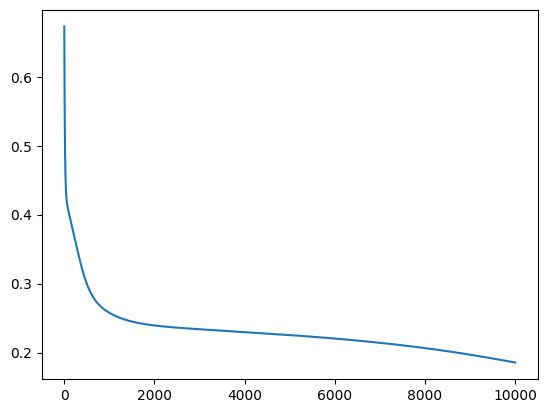

In [6]:
eval_pred_h2 = run_two_hidden_model(1000,5e-3,100)
eval_true = truth_class.detach().numpy()

9720
1.128016
1.386997
2.209619
2.173569
2.029792
0.756178
2.1872
2.168095
2.12424
2.165567
2.083081
2.17151
2.145626
2.124236
2.11219
1.763002
1.702479
1.654359
2.126192
0.887473
2.10968
1.4561860000000002
2.154496
1.302665
2.104961
2.141112
2.075262
2.107771
2.133439
0.828948
1.648968
2.018204
2.074552
2.09424
2.124034
2.15403
2.107
2.024644
2.12317
2.131333
2.108393
2.072792
2.071006
0.706455
2.11132
2.13746
2.13009
2.122245
2.11014
2.12566
2.047721
2.098964
2.147792
2.17566
2.089959
2.144682
2.040654
2.053793
2.13347
2.224161
2.099168
1.284811
2.0714
0.877209
1.994408
0.451423
2.026751
2.130468
1.817381
2.131801
2.040035
2.11263
2.158819
2.1232860000000002
2.121517
2.0742
2.101321
2.13105
2.10318
1.42547
2.031126
2.072344
2.09486
2.1535
2.054696
2.214518
2.116
2.127884
2.070601
1.517404
2.128076
2.091457
2.106169
2.1555
2.137693
2.111181
1.959317
1.478656
2.138166
2.232987
2.100811
0.151802
2.136652
1.96989
2.091003
2.105264
2.21565
2.124165
0.989103
2.1226089999999997
2.049425
2.1

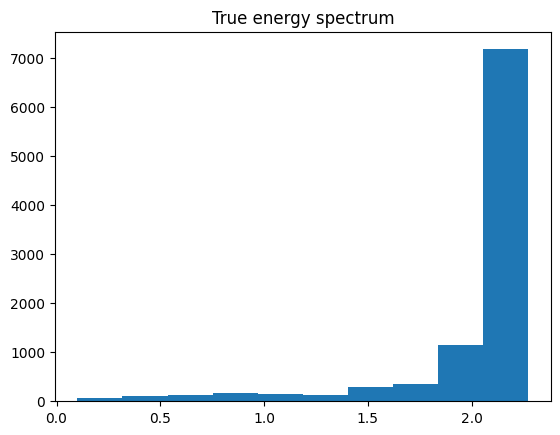

In [7]:
energy_spec = []
unique_ind = np.unique(data[:,0])
print(unique_ind.shape[0])
for i in range(unique_ind.shape[0]):
    ene = np.sum(data[data[:,0] == i,1])
    print (ene)
    energy_spec.append(ene)

plt.hist(energy_spec)
plt.title("True energy spectrum")

print(eval_pred_h2[0].shape)
print(eval_pred_h2[0][1])

print(eval_pred_h2[0])

[[ 0.00000000e+00  1.12801600e+00  9.13283000e-01 -2.69977000e+00
   3.20532033e-01]
 [ 1.00000000e+00  9.52915000e-01  5.19144000e-01  8.78809000e-01
   9.30878204e-01]
 [ 1.00000000e+00  4.34082000e-01  5.67670000e-01 -2.31193600e+00
   9.16612795e-01]
 ...
 [ 9.71800000e+03  2.11805000e+00  6.91111000e-01  1.31600900e+00
   5.89230502e-01]
 [ 9.71900000e+03  1.61018700e+00  1.01372300e+00  2.24618800e+00
   5.36947139e-01]
 [ 9.71900000e+03  1.41488000e-01  1.47488600e+00 -4.42010000e-01
   5.20508288e-01]]
[[ 0.          1.128016    0.913283   -2.69977     0.32053203]
 [ 1.          0.952915    0.519144    0.878809    0.9308782 ]
 [ 1.          0.434082    0.56767    -2.311936    0.91661279]
 [ 2.          2.209619    1.105468    2.333682    0.54709982]]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Connected components: [{0}, {1, 2}, {3}]
<class 'list'>
this is type of k:
1.128016
<class 'set'>
this is type of k:
1.386997
<class 'set'>
this is type of k:
2.20961

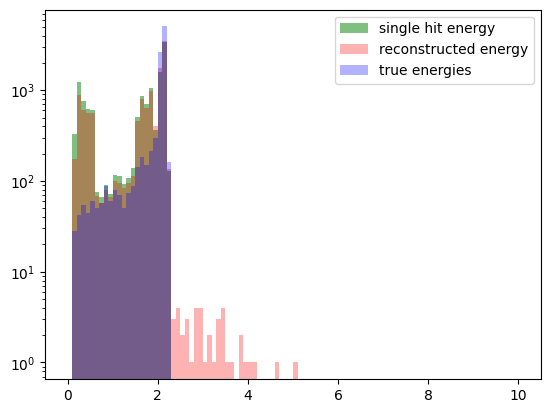

In [8]:
import networkx as nx
print(data)
ene_list = []
idx = 0
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    evt = data[mask]
    print(evt)
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    ##pair indices which belong together...
    pred_comb = []
    for m in range(evt.shape[0]):
        pred_comb.append((m,m))
    for j in range (len(pair_indices)):
        if eval_pred_h2[0][idx+j] > 0.75:
            pred_comb.append(pair_indices[j])
    G = nx.Graph()
    G.add_edges_from(pred_comb)
    connected_components = list(nx.connected_components(G))
    print("Connected components:", connected_components)
    print(type(connected_components))
    for k in range(len(connected_components)):
        print("this is type of k:")
        columns_to_sum = evt[list(connected_components[k]),1]
        ene = np.sum(columns_to_sum)
        ene_list.append(ene)
        print(ene)
        print(type(connected_components[k]))
    idx += len(pair_indices)
single_hit_energies = []
for i in range(data.shape[0]):
    single_hit_energies.append(data[i,1])
    
plt.hist(single_hit_energies,bins=100,range=(0,10),label="single hit energy",color="green",alpha=0.5)    
plt.hist(ene_list,bins=100,range=(0,10),label="reconstructed energy",color="red",alpha=0.3)
plt.hist(energy_spec,bins=100,range=(0,10),label="true energies",color="blue",alpha=0.3)
plt.legend()
plt.yscale('log')
plt.savefig("epoch100.png")
print(eval_pred_h2[0][1])

In [9]:
class feed_forward_model(nn.Module):
        def __init__(self,nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                #self.another_linear = torch.nn.Linear(100,100)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor
def run_out_features(features):
    n_epochs = 10000                                             ##set default n_epochs = 1000
    loss_fn = nn.BCELoss()  # binary cross entropy
    loss_step_vals =[]
    model = feed_forward_model(int(features))
    #optimizer = optim.SGD(model.parameters(), lr=9e-3)  ##set default lr
    optimizer = optim.SGD(model.parameters(), lr=5e-3)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        y_pred = model(input_data)
        y_true = truth_class
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    plt.plot(loss_val)
    print("this is latest loss val:\t",loss_val[-1])
    torch.save(model,"ff_scripted.pt")
    with torch.no_grad():
        model = torch.load("ff_scripted.pt")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]





this is latest loss val:	 0.17447781562805176


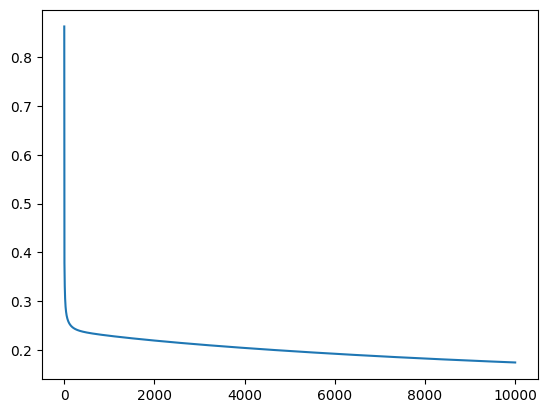

In [10]:
eval_pred_h2 = run_out_features(10000)
eval_true = truth_class.detach().numpy()



[[ 0.00000000e+00  1.12801600e+00  9.13283000e-01 -2.69977000e+00
   3.20532033e-01]
 [ 1.00000000e+00  9.52915000e-01  5.19144000e-01  8.78809000e-01
   9.30878204e-01]
 [ 1.00000000e+00  4.34082000e-01  5.67670000e-01 -2.31193600e+00
   9.16612795e-01]
 ...
 [ 9.71800000e+03  2.11805000e+00  6.91111000e-01  1.31600900e+00
   5.89230502e-01]
 [ 9.71900000e+03  1.61018700e+00  1.01372300e+00  2.24618800e+00
   5.36947139e-01]
 [ 9.71900000e+03  1.41488000e-01  1.47488600e+00 -4.42010000e-01
   5.20508288e-01]]
[[ 0.          1.128016    0.913283   -2.69977     0.32053203]
 [ 1.          0.952915    0.519144    0.878809    0.9308782 ]
 [ 1.          0.434082    0.56767    -2.311936    0.91661279]
 [ 2.          2.209619    1.105468    2.333682    0.54709982]]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Connected components: [{0}, {1, 2}, {3}]
<class 'list'>
this is type of k:
1.128016
<class 'set'>
this is type of k:
1.386997
<class 'set'>
this is type of k:
2.20961

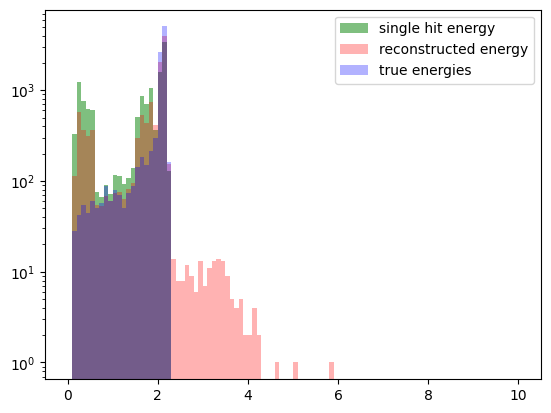

In [11]:
import networkx as nx
print(data)
ene_list = []
idx = 0
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    evt = data[mask]
    print(evt)
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    ##pair indices which belong together...
    pred_comb = []
    for m in range(evt.shape[0]):
        pred_comb.append((m,m))
    for j in range (len(pair_indices)):
        if eval_pred_h2[0][idx+j] > 0.65:
            pred_comb.append(pair_indices[j])
    G = nx.Graph()
    G.add_edges_from(pred_comb)
    connected_components = list(nx.connected_components(G))
    print("Connected components:", connected_components)
    print(type(connected_components))
    for k in range(len(connected_components)):
        print("this is type of k:")
        columns_to_sum = evt[list(connected_components[k]),1]
        ene = np.sum(columns_to_sum)
        ene_list.append(ene)
        print(ene)
        print(type(connected_components[k]))
    idx += len(pair_indices)
single_hit_energies = []
for i in range(data.shape[0]):
    single_hit_energies.append(data[i,1])
    
plt.hist(single_hit_energies,bins=100,range=(0,10),label="single hit energy",color="green",alpha=0.5)    
plt.hist(ene_list,bins=100,range=(0,10),label="reconstructed energy",color="red",alpha=0.3)
plt.hist(energy_spec,bins=100,range=(0,10),label="true energies",color="blue",alpha=0.3)
plt.legend()
plt.yscale('log')
plt.savefig("epoch100.png")
print(eval_pred_h2[0][1])

[1.4637734e-01 4.8061380e-01 3.4983597e-05 ... 1.6387252e-03 3.1972620e-01
 7.6009357e-01]


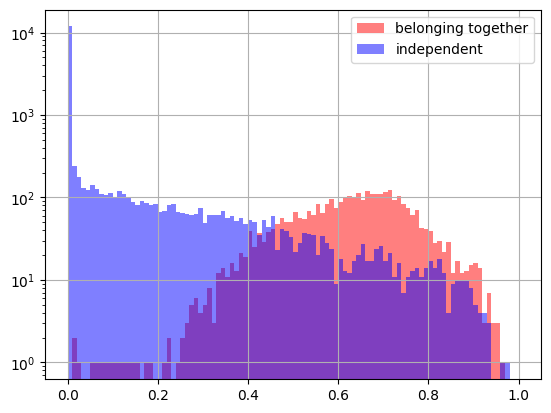

In [12]:
eval_true = eval_true.astype(int)
pred_binaries = eval_pred_h2[0]
print(pred_binaries)

plt.hist(pred_binaries[eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
plt.hist(pred_binaries[eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig("pred_val_distr_single_layer12_features.png")

In [13]:
eval_true.shape
eval_true = eval_true.astype(int)
print(eval_true)

[0 0 0 ... 0 0 1]
